## Project Milestone 2
# Modern Times: Rise of Technology in Cinema

This is a python notebook containing the main code for the Applied Data Analysis project. Please refer to the README.md for an overview of the project.

## Table of contents:
* [Imports](#minusoneth)
* [Data loading](#zeroeth)
* [Exploratory data analysis](#second)
    * [Duplicate data](#second_b)
    * [Missing data](#second_a)
* [Data preprocessing](#first)
* [Focus : Technology in real life](#third)
    * [Lost movies](#third_a)
    * [Silent films & black and white films](#third_b)
    * [Special effects](#third_c)
* [Focus : Technology in movies](#fourth)
    * [Movies about technology](#fourth_a)
        * [Science Fiction & Fantasy](#fourth_a1)
        * [Keyphrase analysis](#fourth_a2)
        * [Historical events](#fourth_a3)
    * [Sentiment analysis](#fourth_b)
* [Next steps](#fifth)


## Imports <a class="anchor" id="minusoneth"></a>

We list the packages used by the project.

* [pandas](https://pandas.pydata.org/) - data handling
* [numpy](https://numpy.org/) - array math
* [seaborn](https://seaborn.pydata.org/) - visualisation
* [matplotlib](https://matplotlib.org/) - visualisation

In [1]:
# Imports
import pandas as pd
import numpy as np
import scipy as scp
import seaborn as sns
from tqdm import tqdm
import matplotlib as mat
import matplotlib.pyplot as plt
from textblob import TextBlob
import IPython.display
from helpers import *
from actors_career_arc import release_by_genre, plot_release_by_genre, actors_by_genre, plot_distrib_actors_by_genre
from scipy.stats import bootstrap
from IPython.display import clear_output
from concurrent.futures import ThreadPoolExecutor, as_completed
# Imports and downloads
import nltk # Natural language processing library
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))
import os
import gzip
import tarfile
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
# Note some of these libraries are not in anaconda by default, meaning you will have to download them before using them-
# Package versions on last run
print_versions([pd, np, sns, mat])

pandas==2.0.3
numpy==1.25.2
seaborn==0.12.2
matplotlib==3.7.2


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/oliviaruggaber/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/oliviaruggaber/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/oliviaruggaber/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Data Loading <a class="anchor" id="zeroeth"></a>

We employ `load_data_with_columns` to read data from the following files as dataframes with named columns. 
* `character.metadata.tsv`
* `movie.metadata.tsv`
* `name.clusters.txt`
* `plot_summaries.txt`
* `tvtropes.clusters.txt`

The column names are listed in `column_names.txt`. Additionally, some date fields are immediately parsed with `date_to_int`.

In [2]:
# Loading the data
DATAFOLDER = '../data/'

# Character metadata
character_metadata = load_data_with_columns(DATAFOLDER, 'character.metadata.tsv')
character_metadata = parse_as_date(character_metadata, 'movie_release_date')

# Movie metadata
movie_metadata = load_data_with_columns(DATAFOLDER, 'movie.metadata.tsv')
movie_metadata = parse_as_date(movie_metadata, 'movie_release_date')

# Plot summaries
plot_summaries = load_data_with_columns(DATAFOLDER, 'plot_summaries.txt')

## Exploratory data analysis <a class="anchor" id="second"></a>

We go ahead and look at the data, at first the number of entries, and we see that it is manageable.

In [3]:
# Display character metadata
display(character_metadata)
print("Number of entries: ", np.prod(character_metadata.shape))

,movie_wikipedia_id,movie_freebase_id,movie_release_date,character_name,actor_birth_date,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,freebase_map_id,character_freebase_id,actor_freebase_id
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg
...,...,...,...,...,...,...,...,...,...,...,...,...,...
450664,913762,/m/03pcrp,1992-05-21,Elensh,1970-05,F,NaN,NaN,Dorothy Elias-Fahn,NaN,/m/0kr406c,/m/0kr406h,/m/0b_vcv
450665,913762,/m/03pcrp,1992-05-21,Hibiki,1965-04-12,M,NaN,NaN,Jonathan Fahn,27.0,/m/0kr405_,/m/0kr4090,/m/0bx7_j
450666,28308153,/m/0cp05t9,NaT,NaN,1941-11-18,M,1.730,/m/02w7gg,David Hemmings,15.0,/m/0g8ngmc,NaN,/m/022g44
450667,28308153,/m/0cp05t9,NaT,NaN,NaN,NaN,NaN,NaN,Roberta Paterson,NaN,/m/0g8ngmj,NaN,/m/0g8ngmm


Number of entries:  5858697


In [4]:
# Display movie metadata
display(movie_metadata)
print("Number of entries: ", np.prod(movie_metadata.shape))

,movie_wikipedia_id,movie_freebase_id,movie_name,movie_release_date,box_office,runtime,languages,countries,genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,[English Language],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]"
2,28463795,/m/0crgdbh,Brun bitter,NaT,NaN,83.0,[Norwegian Language],[Norway],"[Crime Fiction, Drama]"
3,9363483,/m/0285_cd,White Of The Eye,NaT,NaN,110.0,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri..."
4,261236,/m/01mrr1,A Woman in Flames,NaT,NaN,106.0,[German Language],[Germany],[Drama]
...,...,...,...,...,...,...,...,...,...
81736,35228177,/m/0j7hxnt,Mermaids: The Body Found,2011-03-19,NaN,120.0,[English Language],[United States of America],[Drama]
81737,34980460,/m/0g4pl34,Knuckle,2011-01-21,NaN,96.0,[English Language],"[Ireland, United Kingdom]","[Biographical film, Drama, Documentary]"
81738,9971909,/m/02pygw1,Another Nice Mess,1972-09-22,NaN,66.0,[English Language],[United States of America],"[Satire, Comedy]"
81739,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,1992-05-21,NaN,150.0,[Japanese Language],[Japan],"[Science Fiction, Japanese Movies, Adventure, ..."


Number of entries:  735669


In [5]:
# Display plot summaries
display(plot_summaries)
print("Number of entries: ", np.prod(plot_summaries.shape))

,movie_wikipedia_id,plot
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
1,31186339,The nation of Panem consists of a wealthy Capi...
2,20663735,Poovalli Induchoodan is sentenced for six yea...
3,2231378,"The Lemon Drop Kid , a New York City swindler,..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...
...,...,...
42298,34808485,"The story is about Reema , a young Muslim scho..."
42299,1096473,"In 1928 Hollywood, director Leo Andreyev look..."
42300,35102018,American Luthier focuses on Randy Parsons’ tra...
42301,8628195,"Abdur Rehman Khan , a middle-aged dry fruit se..."


Number of entries:  84606


**Initial remarks**
1. There appear to be more rows in movie_metadata than in plot_summaries. This can be due to duplicate or missing data. 

### Duplicate data <a class="anchor" id="second_b"></a>

We show the following: 
1. The wikipedia IDs are unique in `movie_metadata` and `plot_summaries`.
2. There are different movies with exactly the same plot summary text, due to different film industries or remakes of the same movie.

In [6]:
# The wikipedia_id's are unique in both tables.
assert(movie_metadata['movie_wikipedia_id'].is_unique)
assert(plot_summaries['movie_wikipedia_id'].is_unique)

# Summaries with no metadata
movie_metadata_ids = movie_metadata['movie_wikipedia_id'].to_list()
plot_summaries_ids = plot_summaries['movie_wikipedia_id'].to_list()
plot_no_metadata = [id for id in plot_summaries_ids if id not in movie_metadata_ids]

In [7]:
# Duplicate plot texts
duplicated_plots = plot_summaries[plot_summaries['plot'].duplicated(keep=False)]
print("There are {:d} plot summaries that appear more than once.".format(len(duplicated_plots['plot'].unique())))

There are 5 plot summaries that appear more than once.


In [8]:
# Left-merge movie metadata with plots. This disregards the 99 plots with no metadata
movies_with_plots = movie_metadata.merge(plot_summaries, how='left')

# There are movies with different titles but identical plots.
movies_with_plots.set_index('movie_wikipedia_id').loc[duplicated_plots['movie_wikipedia_id']].groupby('plot')['movie_name'].unique().reset_index()

,plot,movie_name
0,A woman is thrown out of her home by her jealo...,"[Madame X, The Trial of Madame X]"
1,An orphan Raghav turns into a ruthless contrac...,"[Antham, Drohi]"
2,"As the American Civil War begins, Ned Burton l...",[The Warrens of Virginia]
3,Raja was adopted by a criminal don at a very ...,[Amar Deep]
4,Taking a step aside from the usual serious dra...,"[Andhamaina Anubhavam, Ninaithale Inikkum]"


What can we know about these movies whose plots appear multiple times?

In [9]:
# Print data about those movies who share a plot with another movie.
movie_metadata[movie_metadata['movie_wikipedia_id'].isin(duplicated_plots['movie_wikipedia_id'])][['movie_name', 'movie_release_date', 'languages', 'countries']].sort_values(by='movie_name')

,movie_name,movie_release_date,languages,countries
22185,Amar Deep,NaT,[Hindi Language],[India]
32255,Amar Deep,NaT,[Hindi Language],[]
59148,Andhamaina Anubhavam,NaT,[Telugu language],[India]
67464,Antham,1992-09-11,[Telugu language],[India]
28621,Drohi,1992-10-25,[Hindi Language],[India]
18993,Madame X,1916-01-14,"[Silent film, English Language]",[United States of America]
49381,Madame X,1920-09-26,"[Silent film, English Language]",[United States of America]
57569,Madame X,NaT,[Greek Language],[Greece]
65014,Madame X,1981-03-16,[English Language],[United States of America]
59142,Ninaithale Inikkum,1979-04-14,[Tamil Language],[India]


**We note the following**:
1. *Andhamaina Anubhavam* / *Ninaithale Inikkum* are the Telugu and Tamil names for the same movie. 
2. *Antham* / *Drohi* are the Telugu and Hindi names for the same movie.
3. There are multiple movie adaptations of the play *(The Trial of) Madame X*. 
4. There is a "lost" 1924 version of the movie The Warrens of Virginia, with the same plot, but it appears in this dataset.
5. The movie *Amar Deep* appearing twice appears to simply be a dataset error.

### Missing data <a class="anchor" id="second_a"></a>

We show the following:
1. The wikipedia IDs in `plot_summaries` are not a subset of those in `movie_metadata`, as there are 99 summaries with no associated metadata. 
2. The percentage of missing plot summaries per decade **decreases**, while the absolute number of missing plot summaries **increases**.

In [10]:
# Number of summaries with no metadata.
print("There are {:d} plot summaries with no associated metadata".format(len(plot_no_metadata)))
plot_summaries.set_index('movie_wikipedia_id').loc[plot_no_metadata].reset_index()

There are 99 plot summaries with no associated metadata


,movie_wikipedia_id,plot
0,2862137,Sathyanarayan Murthy is a rough but kind man ...
1,33334420,{{more plot}} Mural tells the story of Zhu Xia...
2,16758721,"The story is about a young man “Tony”, a 25 ye..."
3,23217064,"Years before the events of the first film, Lo..."
4,2746943,"A young 16-year-old girl, Zhu Ying Tai, manage..."
...,...,...
94,35607003,Parisian Marion is living in New York with her...
95,32942181,"Rajat , Nishant ""Liquid"" Agarwal and Vikrant ..."
96,133671,Gerry Conlon is shown in Belfast stripping le...
97,34076714,"After a hit gone wrong, Nikita, an exiled Russ..."


What is the percentage of missing plot summary data per decade?

In [11]:
# Bin movies into decades
movies_with_decades = bin_into_decades(movies_with_plots, 'movie_release_date').copy()

# Bootstrap parameters
bootstrap_args = {'statistic' : percent_nans, 'n_resamples':100, 'confidence_level':0.95, 'alternative':'two-sided', 'method':'percentile'}

# Groupby decades
plots_by_decade = movies_with_decades.groupby('decade', observed=False, group_keys=True)['plot']

# Perform bootstrap estimation of missing plot summary data
intervals_by_decade = plots_by_decade.apply(lambda x: bootstrap((duplicate_singleton(x), ), **bootstrap_args).confidence_interval[:])

# Unpack intervals into dataframe
low_high_by_decade = expand_list_data(pd.DataFrame(intervals_by_decade).set_axis(['interval'],axis=1), 'interval', ['low', 'high']).copy()

# Put data together
missing_plots = pd.concat([pd.DataFrame({
    'mean':plots_by_decade.apply(percent_nans), 
    'count':plots_by_decade.apply(lambda x: x.isnull().sum())}), 
    low_high_by_decade], axis=1)

In [12]:
movies_with_plots

,movie_wikipedia_id,movie_freebase_id,movie_name,movie_release_date,box_office,runtime,languages,countries,genres,plot
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...","Set in the second half of the 22nd century, th..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,[English Language],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]",NaN
2,28463795,/m/0crgdbh,Brun bitter,NaT,NaN,83.0,[Norwegian Language],[Norway],"[Crime Fiction, Drama]",NaN
3,9363483,/m/0285_cd,White Of The Eye,NaT,NaN,110.0,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",A series of murders of rich young women throug...
4,261236,/m/01mrr1,A Woman in Flames,NaT,NaN,106.0,[German Language],[Germany],[Drama],"Eva, an upper class housewife, becomes frustra..."
...,...,...,...,...,...,...,...,...,...,...
81736,35228177,/m/0j7hxnt,Mermaids: The Body Found,2011-03-19,NaN,120.0,[English Language],[United States of America],[Drama],Two former National Oceanic Atmospheric Admini...
81737,34980460,/m/0g4pl34,Knuckle,2011-01-21,NaN,96.0,[English Language],"[Ireland, United Kingdom]","[Biographical film, Drama, Documentary]",{{No plot}} This film follows 12 years in the ...
81738,9971909,/m/02pygw1,Another Nice Mess,1972-09-22,NaN,66.0,[English Language],[United States of America],"[Satire, Comedy]",NaN
81739,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,1992-05-21,NaN,150.0,[Japanese Language],[Japan],"[Science Fiction, Japanese Movies, Adventure, ...","The story takes place in the year 2092,The Sup..."


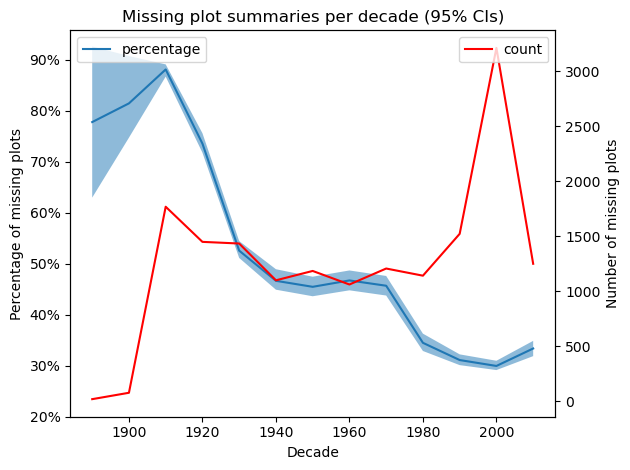

In [13]:
# Plot percentage and count
fig, ax1 = plt.subplots()
ax1.set_title(f"Missing plot summaries per decade (95% CIs)")
ax1.set_xlabel("Decade")
ax1.set_ylabel("Percentage of missing plots")
plot_with_confidence(missing_plots, 'mean', 'percentage', ax1)
ax1.set_yticks(ticks=ax1.get_yticks()[:-1], labels=["{:.0f}%".format(p*100) for p in ax1.get_yticks()[:-1]])
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.set_ylabel('Number of missing plots')
ax2.plot(missing_plots['count'], label = 'count', color='red')
ax2.legend(loc='upper right')
ax2.tick_params(axis='y')

fig.tight_layout()
plt.show()

### Missing data Recovery <a class="anchor" id="second_a"></a>

In [14]:
print(movies_with_plots.isnull().sum())

movie_wikipedia_id        0
movie_freebase_id         0
movie_name                0
movie_release_date    42369
box_office            73340
runtime               20450
languages                 0
countries                 0
genres                    0
plot                  39537
dtype: int64


As we can see above, we have many missing values. In this section we try to recover as many as possible by doing a web scraping process.
We start by recovering movie release date and movie box office revenues. As this process takes a lot of time we saved the obtained values in csv files but we still show the code for it.
For the release date we take advantage of the wikipedia ID to look at wikipedia pages to retrieve the release year with the URL of this structure: "https://en.wikipedia.org/wiki?curid={wikipedia_id}". 
For the box office revenues we use the website "https://www.boxofficemojo.com/" which uses IMDb ID. So we import the file links that maps wikipedia, freebase and imdb IDs.

In [15]:
links = pd.read_table(DATAFOLDER + '/wikidata_freebase_imdb.tsv')
links_free_imdb = links[['Freebase_ID', 'IMDb_ID']]
links_free_imdb.rename(columns={'Freebase_ID': 'movie_freebase_id'}, inplace=True)
links_free_imdb.rename(columns={'IMDb_ID': 'movie_imdb_id'}, inplace=True)
links_free_imdb = links_free_imdb.drop_duplicates(subset='movie_freebase_id')
clear_output()

In [16]:
movies_with_imdb_id = movies_with_plots.copy()
movies_with_imdb_id = pd.merge(movies_with_imdb_id, links_free_imdb, on='movie_freebase_id', how='left')

In [17]:
# Identifying rows with missing data
missing_release_date = movies_with_imdb_id[movies_with_imdb_id['movie_release_date'].isnull()][['movie_wikipedia_id', 'movie_release_date']]
missing_box_office = movies_with_imdb_id[movies_with_imdb_id['box_office'].isnull()][['movie_wikipedia_id', 'box_office', 'movie_imdb_id']]

In [18]:
SCRATCH_SCRAPE = False

if SCRATCH_SCRAPE:
    for index, row in tqdm(missing_release_date.iterrows(), total=missing_release_date.shape[0]):
        wikipedia_id = row['movie_wikipedia_id']
        release_year = get_movie_release_year(wikipedia_id)
        
        if release_year:
            # Update the release_date column with the found release year
            missing_release_date.at[index, 'movie_release_date'] = release_year
        else:
            print(f"No release year found for Wikipedia ID: {wikipedia_id}")

    missing_release_date = missing_release_date.dropna(subset='movie_release_date')
    missing_release_date.to_csv(DATAFOLDER + 'missing_release_date.csv', index=False) 

    imdb_ids = missing_box_office['movie_imdb_id'].tolist() 
    
    with ThreadPoolExecutor(max_workers=10) as executor:  # Use ThreadPoolExecutor for parallel processing
        future_to_imdb_id = {executor.submit(scrape_box_office, imdb_id): imdb_id for imdb_id in imdb_ids}
        for future in tqdm(as_completed(future_to_imdb_id), total=len(imdb_ids)):
            imdb_id = future_to_imdb_id[future]
            try:
                box_office = future.result()
                if box_office:
                    missing_box_office.loc[missing_box_office['movie_imdb_id'] == imdb_id, 'box_office'] = box_office
            except Exception as e:
                print(f"Error processing {imdb_id}: {e}")

    missing_box_office = missing_box_office.dropna(subset='box_office')
    missing_box_office.to_csv(DATAFOLDER + 'missing_box_office.csv', index=False) 

else:
    missing_release_date = pd.read_csv(DATAFOLDER + '/missing_release_date.csv')
    missing_box_office = pd.read_csv(DATAFOLDER + '/missing_box_office.csv')


Update the main DataFrame with new found values

In [19]:
# Merge the two dataframes on 'wikipedia_id' while keeping all records from movies_metadata
merged_df = pd.merge(movies_with_imdb_id, missing_box_office[['movie_wikipedia_id', 'box_office']], on='movie_wikipedia_id', how='left', suffixes=('', '_missing'))

# Where box_office_missing is not NaN, update the box_office in movies_metadata
merged_df['box_office'] = merged_df['box_office_missing'].where(merged_df['box_office_missing'].notna(), merged_df['box_office'])

# Drop the temporary 'box_office_missing' column
merged_df.drop(columns=['box_office_missing'], inplace=True)

# Merge the two dataframes on 'wikipedia_id' while keeping all records from movies_metadata
merged_df = pd.merge(merged_df, missing_release_date[['movie_wikipedia_id', 'movie_release_date']], on='movie_wikipedia_id', how='left', suffixes=('', '_missing'))

# Where box_office_missing is not NaN, update the box_office in movies_metadata
merged_df['movie_release_date'] = merged_df['movie_release_date_missing'].where(merged_df['movie_release_date_missing'].notna(), merged_df['movie_release_date'])

# Drop the temporary 'box_office_missing' column
merged_df.drop(columns=['movie_release_date_missing'], inplace=True)

In [20]:
print(merged_df.isnull().sum())

movie_wikipedia_id        0
movie_freebase_id         0
movie_name                0
movie_release_date    37877
box_office            66568
runtime               20450
languages                 0
countries                 0
genres                    0
plot                  39537
movie_imdb_id          7986
dtype: int64


### Data Visualisation

Let's visualize some quantities that can be for use in the following analysis and to have a look at the data.

In [21]:
# Copy the movie dataframe already created and convert dates into years as integers.

movies_df = movie_metadata.copy()
movies_df['movie_release_date'] = movies_df['movie_release_date'].apply(lambda x : x.year)
movies_df['movie_release_date'] = movies_df['movie_release_date'].fillna(0).astype(int)

movies_df = movies_df[movies_df['movie_release_date'] > 1850]

characters_df = character_metadata.copy()
characters_df['movie_release_date'] = characters_df['movie_release_date'].apply(lambda x : x.year)
characters_df['movie_release_date'] = characters_df['movie_release_date'].fillna(0).astype(int)
characters_df = date_to_float(characters_df, 'actor_birth_date')

characters_df = characters_df[characters_df['movie_release_date'] > 1850]

movies_analysis_df = movie_metadata.copy()
movies_df['movie_release_date'] = movies_analysis_df['movie_release_date'].apply(lambda x : x.year)
movies_analysis_df['movie_release_date'] = movies_analysis_df['movie_release_date'].fillna(0).astype(int)

(0.0, 1600.0)

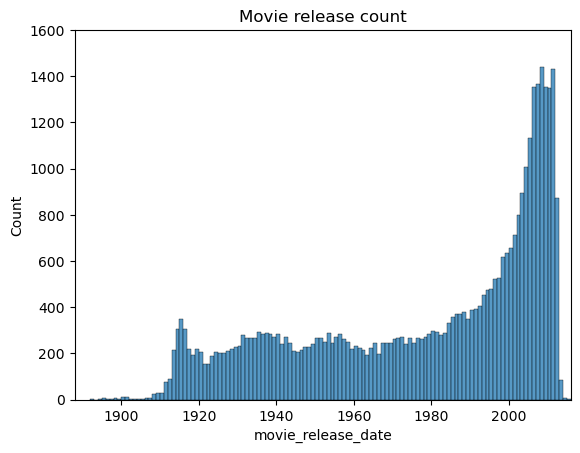

In [22]:
# Movie Release Count
# Time trends of different aspects will be analysed in this project. 
# Let's first have a look on the general trend of movie releasing across time
fig, ax = plt.subplots()
sns.histplot(data=movies_df, x='movie_release_date', ax = ax, binwidth=1).set(title='Movie release count')
ax.set_xlim(1888, 2016)
ax.set_ylim(0,1600)

It is very interesting to note that the movie industry only really started in the 10's and then had a continuous release rate until the beginning of the 21st century. Further research could look for important technological events that correlate with these trends

In [23]:
# Genre Distribution
# Genre are impacted differently by technology
# Let's have a look at the genre distribution, in total and across time for the main genres of interest

# Flatten the list of genres
all_genres = [genre for sublist in movies_df['genres'] for genre in sublist]

# Create a pandas Series from the flattened list
genre_counts = pd.Series(all_genres).value_counts()

genre_counts

Drama                   17591
Comedy                   9456
Romance Film             5849
Black-and-white          5635
Thriller                 4983
                        ...  
Camp                        1
Clay animation              1
Hardcore pornography        1
Z movie                     1
Race movie                  1
Name: count, Length: 348, dtype: int64

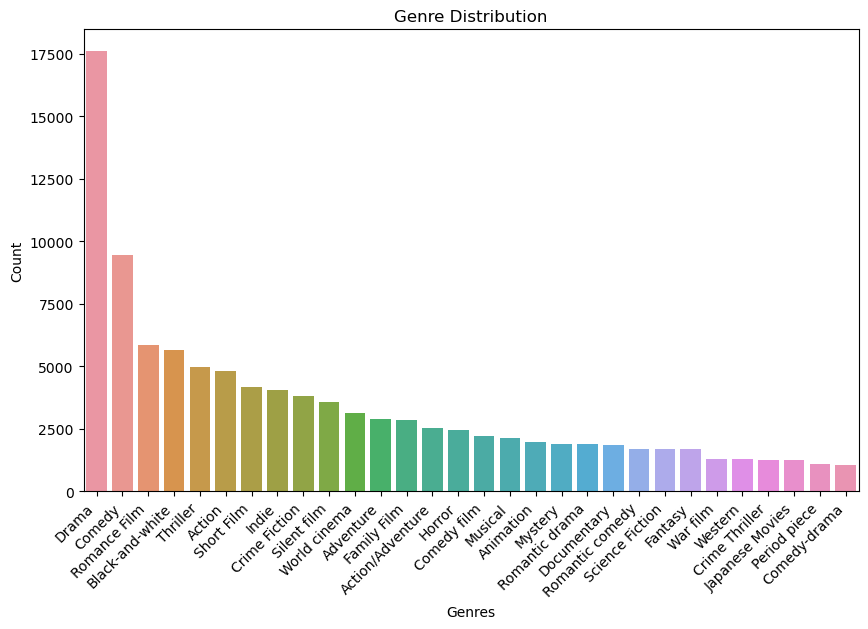

In [24]:
# Plot Genre Distribution
top30_genre = genre_counts.nlargest(30)

plt.figure(figsize=(10, 6))  
sns.barplot(x=top30_genre.index, y=top30_genre.values)
plt.title('Genre Distribution')
plt.xlabel('Genres')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')  
plt.show()

Drama, comedy and romance lead in the top 3. The genre of interest (see below) are included in the top 30 genres in the 363 long list of genre categories. Their number and presence is therefore non negligible.

Let's now look at the evolution in time of certain genre of interest. 
- SF: as it is one of the main genres excplicitly dealing with technology
- Fantasy: as new technologies permits better rendering and thus popularity of the genre
- Black and white & Silent Film: to look at the drop coming after the begining of color and sound
- War films: Wars are also heavily shaped by technology

In [25]:
genre_stats_per_year = movies_df.groupby(movies_df['movie_release_date']).apply(lambda x: pd.Series({
    'SF': pd.Series([genre for sublist in x['genres'] for genre in sublist]).value_counts().get('Science Fiction', 0),
    'Fantasy': pd.Series([genre for sublist in x['genres'] for genre in sublist]).value_counts().get('Fantasy', 0),
    'Black-and-white': pd.Series([genre for sublist in x['genres'] for genre in sublist]).value_counts().get('Black-and-white', 0),
    'Silent film':pd.Series([genre for sublist in x['genres'] for genre in sublist]).value_counts().get('Silent film', 0),
    'War film':pd.Series([genre for sublist in x['genres'] for genre in sublist]).value_counts().get('War film', 0)
}))

In [26]:
genre_stats_per_year.SF

movie_release_date
1892     0
1894     0
1895     0
1896     0
1897     0
        ..
2011    72
2012    35
2013    14
2014     0
2016     0
Name: SF, Length: 123, dtype: int64

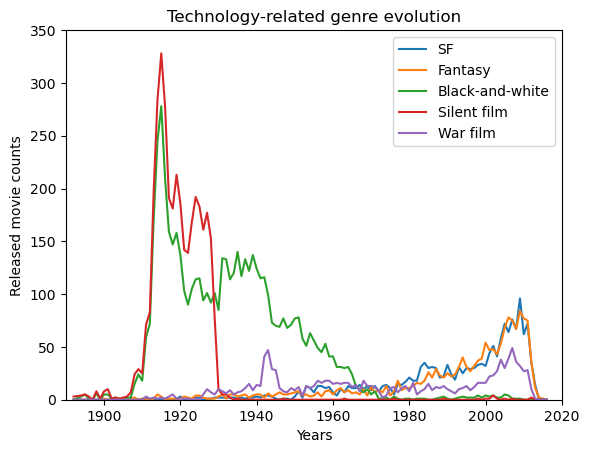

In [27]:
plt.plot(genre_stats_per_year.index.to_numpy(), genre_stats_per_year.SF.to_numpy(), label = 'SF')
plt.plot(genre_stats_per_year.index.to_numpy(), genre_stats_per_year.Fantasy.to_numpy(), label = 'Fantasy')
plt.plot(genre_stats_per_year.index.to_numpy(), genre_stats_per_year['Black-and-white'].to_numpy(), label = 'Black-and-white')
plt.plot(genre_stats_per_year.index.to_numpy(), genre_stats_per_year['Silent film'].to_numpy(), label = 'Silent film')
plt.plot(genre_stats_per_year.index.to_numpy(), genre_stats_per_year['War film'].to_numpy(), label = 'War film')


plt.xlabel("Years")
plt.ylabel("Released movie counts")
plt.xlim(1890,2020)
plt.ylim(0,350)
plt.title("Technology-related genre evolution")
plt.legend()
plt.show()

While Black-and-white, as well as Silent films have a very different trend from the general one, SF and Fantasy are slowly growing genre. War films follow a similar trend - while being less popular and having a special peak after the 2nd World War.

To better visualize the growing popularity - or not - of SF and Fantasy and remove the confounder of a generally growing movie industry, let's make a proportion plot.

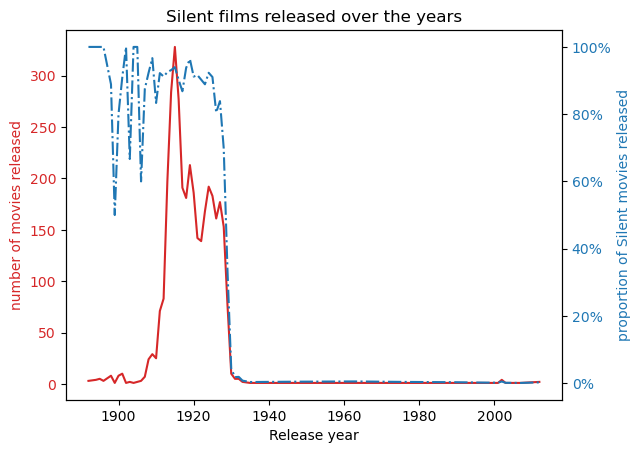

,frequency,total_nb_films
movie_release_date,,
1932,5,267
1892,3,3
1918,181,193
1901,10,11
1976,1,268


In [28]:
#Dataframe grouping Silent films by year and indicating the number of silent films relased, as well as the total number of films released in that year
mute_films, mute_films_by_year = release_by_genre(movies_df)
plot_release_by_genre(mute_films_by_year)

#Display resulting dataframe
display(mute_films_by_year.sample(5))

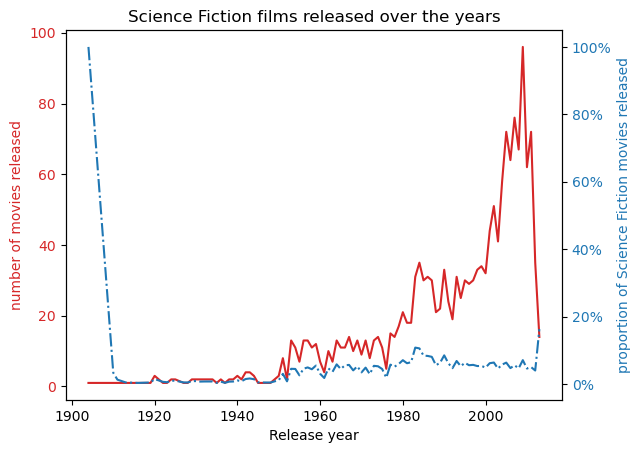

In [30]:
# Dataframe grouping genre films by year and indicating the number of genre films released, as well as the total number of films released in that year
sf_films, sf_films_by_year = release_by_genre(movies_df, 'Science Fiction')
sf_films_by_year = sf_films_by_year.drop(index = sf_films_by_year.index[0])

# Plot the proportion and number of movies released in time for genre
plot_release_by_genre(sf_films_by_year, 'Science Fiction')

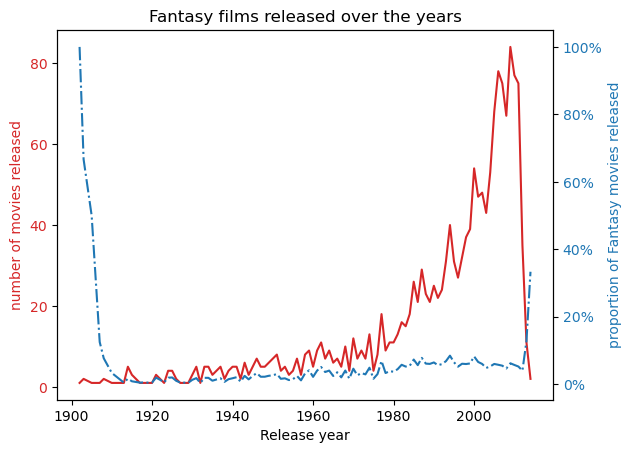

In [68]:
# Dataframe grouping genre films by year and indicating the number of genre films released, as well as the total number of films released in that year
fts_films, fts_films_by_year = release_by_genre(movies_df, 'Fantasy')
fts_films_by_year = fts_films_by_year.drop(index = fts_films_by_year.index[0])

# Plot the proportion and number of movies released in time for genre
plot_release_by_genre(fts_films_by_year, 'Fantasy')


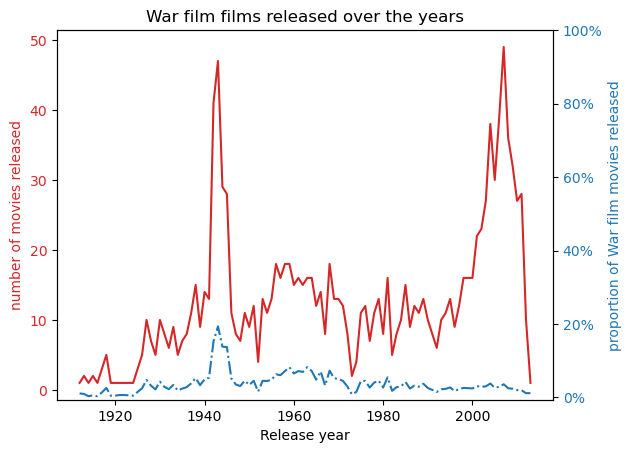

In [69]:
# Dataframe grouping genre films by year and indicating the number of genre films released, as well as the total number of films released in that year
wf_films, wf_films_by_year = release_by_genre(movies_df, 'War film')
wf_films_by_year = wf_films_by_year.drop(index = wf_films_by_year.index[0])

# Plot the proportion and number of movies released in time for genre
plot_release_by_genre(wf_films_by_year, 'War film')

- SF: Is proportionately almost not a growing field with time, but went a bit up in the 50's. There is a high proportion peak in the old days, but this can be explained by the small number of released movies: even only with one movie enterin the category, the proportion number severely goes up. 
- Fantasy: Similar trends can be observed. 
- War: There is still a very visible peak after the 40's, probably caused by the 2nd World War, an event so predominant in the culture that up to half of the movies released in the following years correspond to war films. The trend is nevertheless going down from the 60's to now.

For Black-and-White analysis, please look at the corresponding section. 

### Importing new datasets <a class="anchor" id="second_a"></a>

For further analysis we use movie reviews from rottentomatoes and movie ratings from IMDb.

In [33]:
critic_reviews = pd.read_csv(DATAFOLDER + 'rotten_tomatoes_critic_reviews.csv')
critic_reviews['review_date'] = critic_reviews['review_date'].str[0:4].astype(float)

In [34]:
# Filter for 'Fresh' reviews
fresh_reviews = critic_reviews[critic_reviews['review_type'] == 'Fresh']

# Calculate the percentage
percentage_fresh = (len(fresh_reviews) / len(critic_reviews)) * 100

print(f"Percentage of Fresh Reviews: {percentage_fresh:.2f}%")

Percentage of Fresh Reviews: 63.73%


In [35]:
critic_reviews = critic_reviews[['rotten_tomatoes_link', 'review_content', 'review_date']]
rotten_tomatoes_movies = pd.read_csv(DATAFOLDER + '/rotten_tomatoes_movies.csv')
rotten_tomatoes_movies = rotten_tomatoes_movies[['rotten_tomatoes_link', 'movie_title', 'original_release_date']]
critic_reviews = pd.merge(critic_reviews, rotten_tomatoes_movies, on='rotten_tomatoes_link', how='left')
critic_reviews['original_release_date'] = critic_reviews['original_release_date'].str[0:4].astype(float)

In [36]:
print(critic_reviews.isnull().sum())

rotten_tomatoes_link         0
review_content           65806
review_date                  0
movie_title                130
original_release_date    23230
dtype: int64


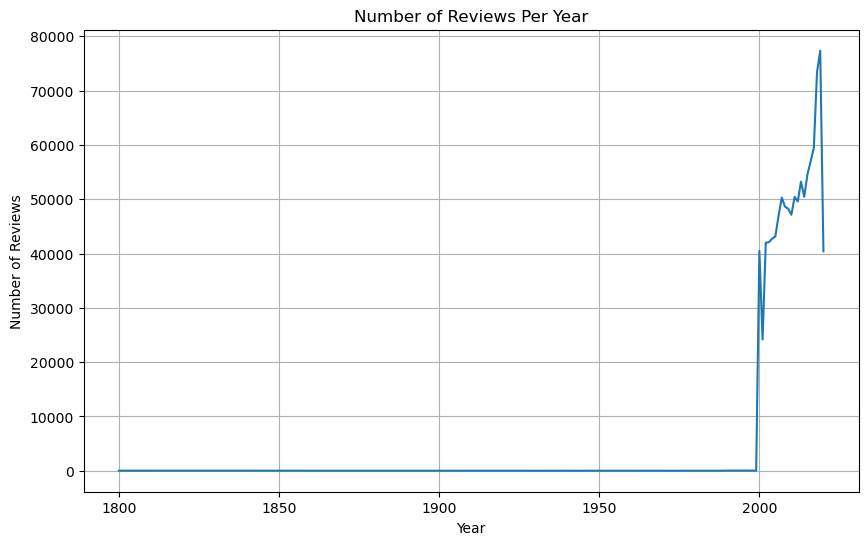

In [37]:
critic_reviews = critic_reviews.dropna()

# Count the number of reviews per year
review_counts = critic_reviews['review_date'].value_counts().sort_index()

# Plotting
plt.figure(figsize=(10, 6))

# For a line graph
plt.plot(review_counts.index, review_counts.values)

plt.title('Number of Reviews Per Year')
plt.xlabel('Year')
plt.ylabel('Number of Reviews')
plt.grid(True)
plt.show()

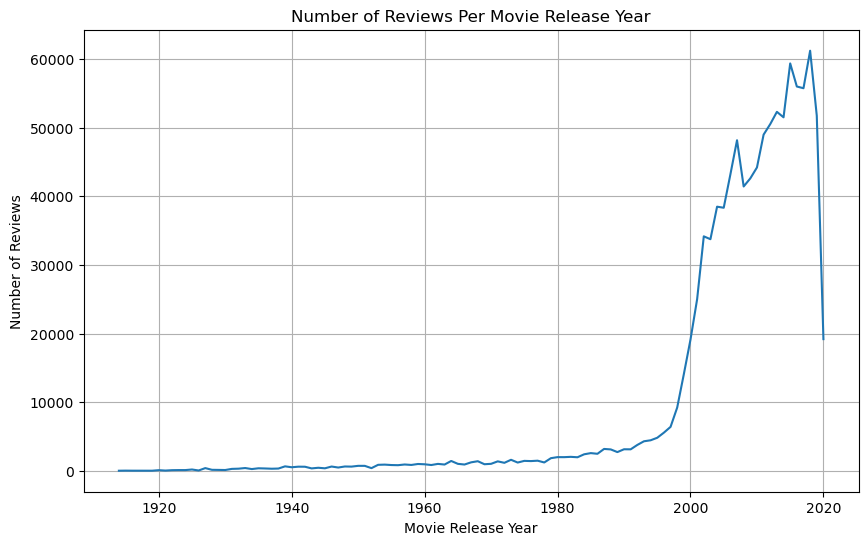

In [38]:
# Count the number of reviews per year
review_counts_movie_year = critic_reviews['original_release_date'].value_counts().sort_index()

# Plotting
plt.figure(figsize=(10, 6))

# For a line graph
plt.plot(review_counts_movie_year.index, review_counts_movie_year.values)

# For a bar chart (uncomment the next line and comment out the line graph line above)
# plt.bar(review_counts.index, review_counts.values)

plt.title('Number of Reviews Per Movie Release Year')
plt.xlabel('Movie Release Year')
plt.ylabel('Number of Reviews')
plt.grid(True)
plt.show()

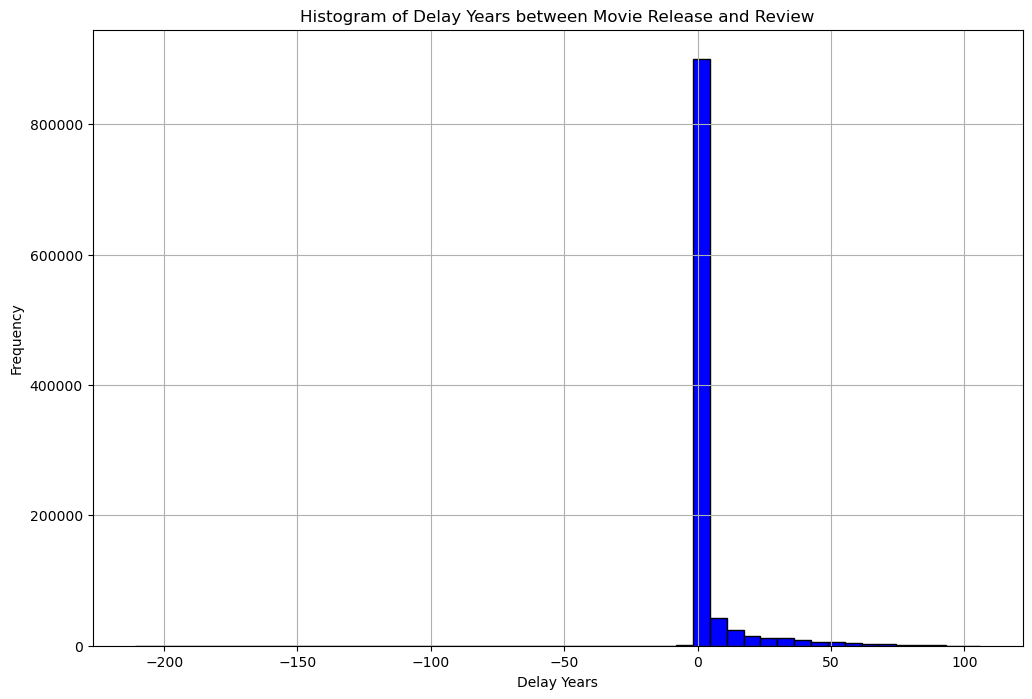

In [39]:
# Calculate the delay
critic_reviews['delay'] = (critic_reviews['review_date'] - critic_reviews['original_release_date'])

# Plotting the histogram
plt.figure(figsize=(12, 8))
plt.hist(critic_reviews['delay'], bins=50, color='blue', edgecolor='black')

plt.title('Histogram of Delay Years between Movie Release and Review')
plt.xlabel('Delay Years')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [40]:
# Exploratory Counts
critic_reviews['word_count'] = critic_reviews['review_content'].apply(word_count)
critic_reviews['sentence_count'] = critic_reviews['review_content'].apply(sentence_count)

# Initial sentiment analysis
critic_reviews['sentiment'] = critic_reviews['review_content'].apply(lambda x: TextBlob(x).sentiment.polarity)

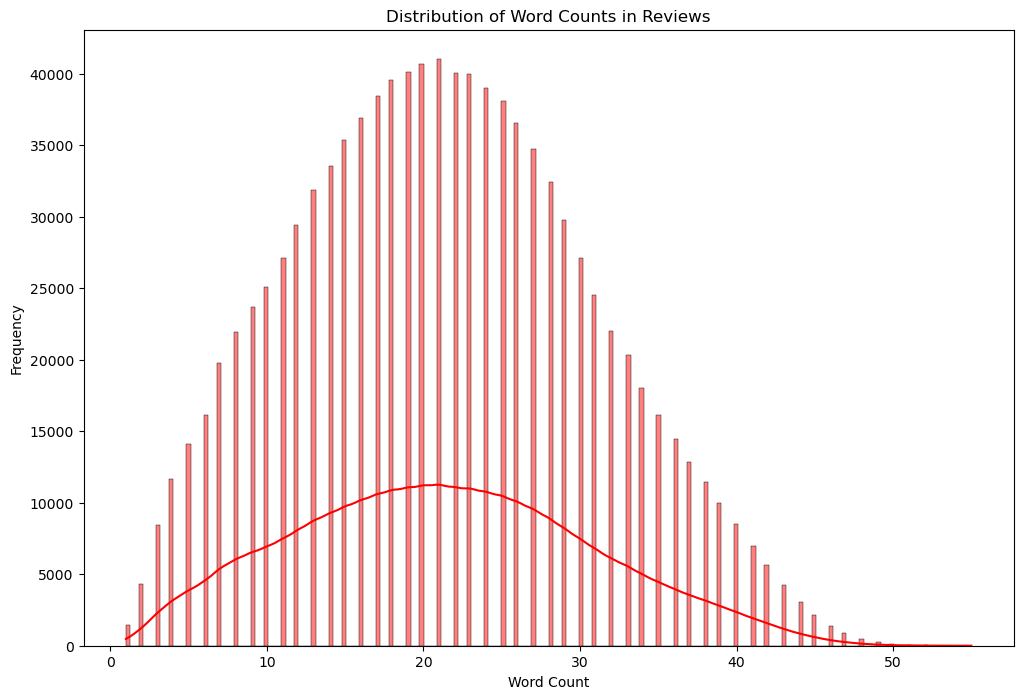

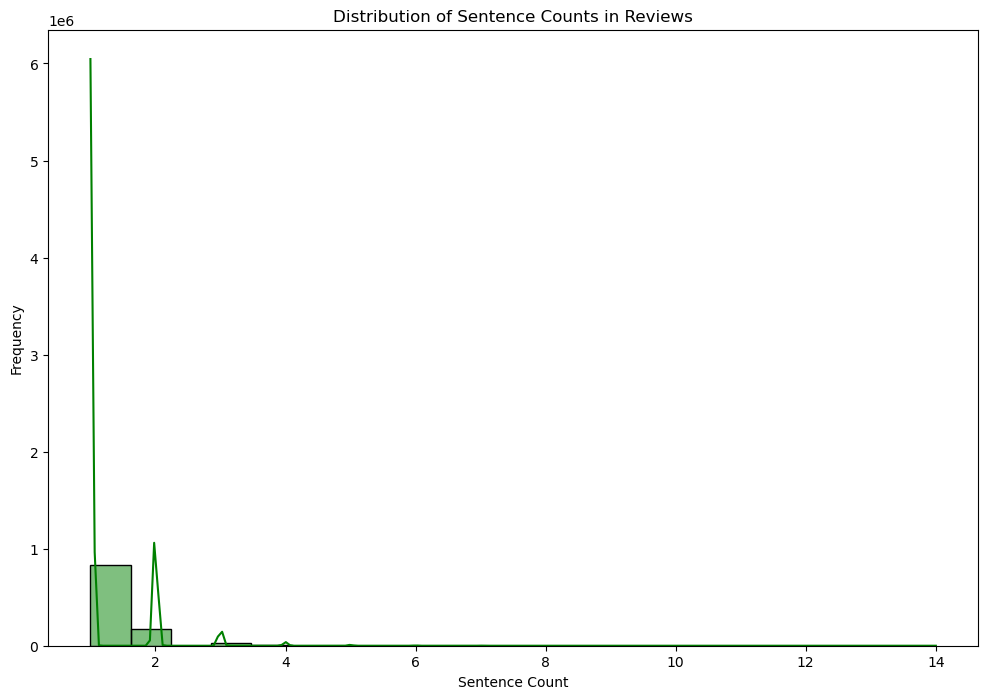

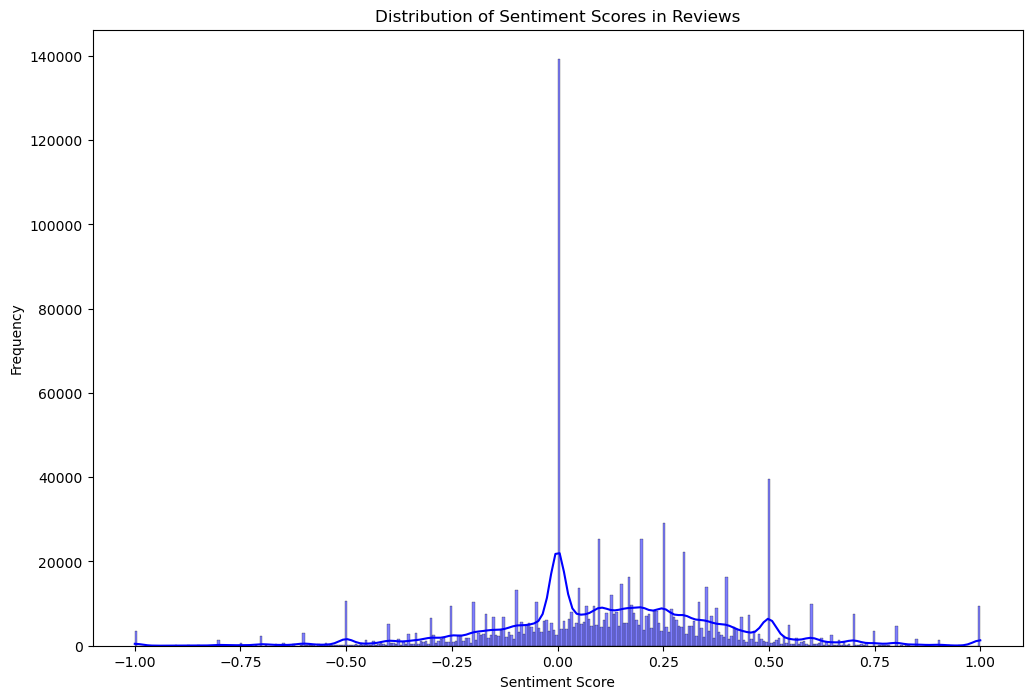

In [41]:
plt.figure(figsize=(12, 8))
sns.histplot(critic_reviews['word_count'], kde=True, color='red')
plt.title('Distribution of Word Counts in Reviews')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(12, 8))
sns.histplot(critic_reviews['sentence_count'], kde=True, color='green')
plt.title('Distribution of Sentence Counts in Reviews')
plt.xlabel('Sentence Count')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(12, 8))
sns.histplot(critic_reviews['sentiment'], kde=True, color='blue')
plt.title('Distribution of Sentiment Scores in Reviews')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()

In [42]:
merged_df_reviews = merged_df.copy()
# Function to clean and lowercase movie titles
def clean_title(title):
    if isinstance(title, str):
        return re.sub(r'[^a-z0-9]', '', title.lower())
    else:
        # If the title is not a string, return an empty string or handle as needed
        return ''

# Function to create a combined key of cleaned title and release date
def create_combined_key(title, date):
    cleaned_title = clean_title(title)
    return f"{cleaned_title}_{date}"

# Applying the combined key function to both dataframes
merged_df_reviews['title_date_key'] = merged_df_reviews.apply(lambda x: create_combined_key(x['movie_name'], x['movie_release_date']), axis=1)
critic_reviews['title_date_key'] = critic_reviews.apply(lambda x: create_combined_key(x['movie_title'], x['original_release_date']), axis=1)

# Checking how many combined keys (title and date) are common between the two dataframes
common_title_date_keys_count = merged_df_reviews[merged_df_reviews['title_date_key'].isin(critic_reviews['title_date_key'])].shape[0]
common_title_date_keys_count

43

## Data preprocessing  <a class="anchor" id="first"></a>

### Plot summaries preprocessing

In [43]:
tqdm.pandas() 
plot_summaries['preprocessed_text'] = plot_summaries['plot'].progress_apply(preprocess)
plot_summaries['clean_text'] = plot_summaries['preprocessed_text'].progress_apply(clean_sent_advanced)
plot_summaries['sentence_tokens'] = plot_summaries['plot'].progress_apply(tokenize_sentences)
plot_summaries['word_tokens'] = plot_summaries['clean_text'].progress_apply(tokenize_words)

100%|██████████| 42303/42303 [00:15<00:00, 2814.42it/s]


In [44]:
# Add column that counts the number of sentences
plot_summaries['sentence_count'] = plot_summaries['sentence_tokens'].apply(len)

# Add column that counts the number of sentences
plot_summaries['word_count'] = plot_summaries['word_tokens'].apply(len)

In [45]:
plot_summaries['sentence_count'].describe()

count    42303.000000
mean        15.693071
std         16.605600
min          1.000000
25%          4.000000
50%          9.000000
75%         23.000000
max        344.000000
Name: sentence_count, dtype: float64

In [46]:
plot_summaries['word_count'].describe()

count    42303.000000
mean       146.877739
std        149.044434
min          1.000000
25%         42.000000
50%         89.000000
75%        214.000000
max       2205.000000
Name: word_count, dtype: float64

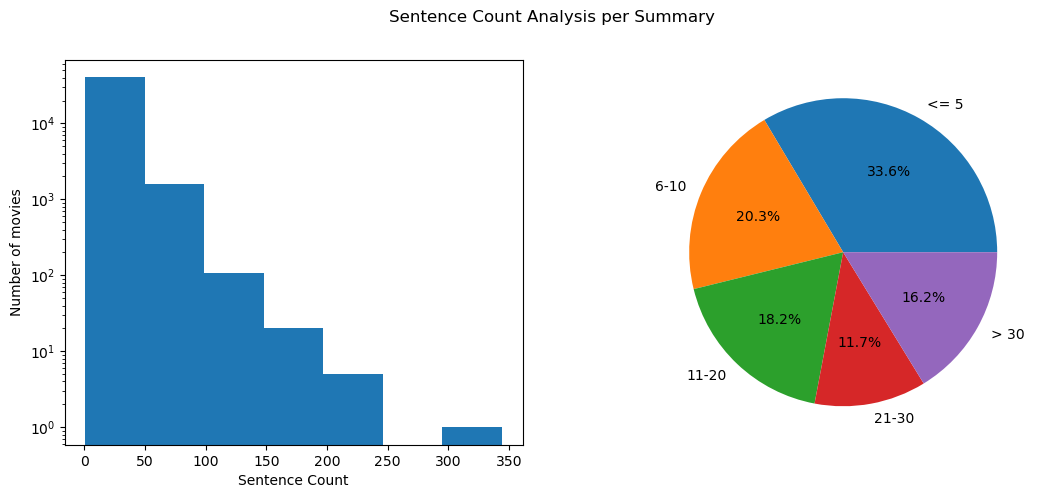

In [47]:
# Creating subplots for histogram and pie chart
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (13, 5))

# Histogram for sentence counts
ax1.hist(plot_summaries['sentence_count'], bins=round(plot_summaries['sentence_count'].max()/50))
ax1.set_yscale('log')
ax1.set_ylabel('Number of movies')
ax1.set_xlabel('Sentence Count')

# Pie chart for sentence count ranges
ax2.pie([
    plot_summaries[plot_summaries['sentence_count'] <= 5].shape[0],
    plot_summaries[(plot_summaries['sentence_count'] > 5) & (plot_summaries['sentence_count'] <= 10)].shape[0],
    plot_summaries[(plot_summaries['sentence_count'] > 10) & (plot_summaries['sentence_count'] <= 20)].shape[0],
    plot_summaries[(plot_summaries['sentence_count'] > 20) & (plot_summaries['sentence_count'] <= 30)].shape[0],
    plot_summaries[plot_summaries['sentence_count'] > 30].shape[0]],
    labels=['<= 5', '6-10', '11-20', '21-30', '> 30'], autopct='%1.1f%%')

# Setting title for the entire figure
plt.suptitle('Sentence Count Analysis per Summary')
plt.show()

#### Plot summaries word count

We show that the word-counts follows a negative exponential distribution (y axis is in logarithmic scale). Most films have a short summary: most of them have a word-count below 500 words. In fact, nearly half of the dataset lies in the 100 to 500 words range. A very low percentage of films have a summary above 1000. Thus there might be a disparity in the precision of the plot due to the difference in length. Thus, longer plot summaries have higher chances of including multiple and more precise tech-related or event-related keywords.

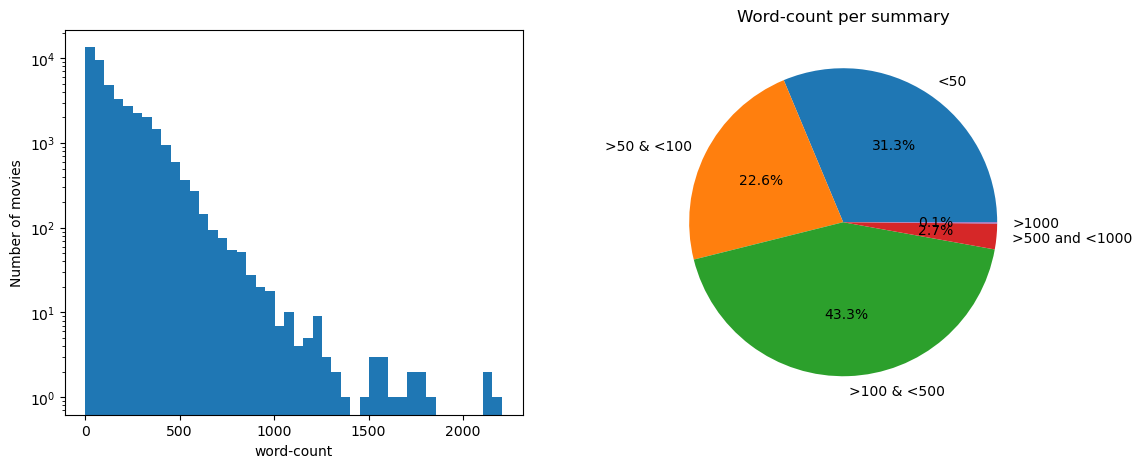

In [48]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (13, 5))
ax2.pie([plot_summaries[plot_summaries['word_count'] <= 50].shape[0], plot_summaries[(plot_summaries['word_count'] > 50)&(plot_summaries['word_count'] <= 100)].shape[0], plot_summaries[(plot_summaries['word_count'] > 100)&(plot_summaries['word_count'] <= 500)].shape[0],
          plot_summaries[(plot_summaries['word_count'] > 500)&(plot_summaries['word_count'] <= 1000)].shape[0], plot_summaries[plot_summaries['word_count'] > 1000].shape[0]],
          labels = ['<50', '>50 & <100', '>100 & <500', '>500 and <1000', '>1000'], autopct='%1.1f%%')
ax1.hist(plot_summaries['word_count'], bins= round(plot_summaries['word_count'].max()/50))
ax1.set_yscale('log')
ax1.set_ylabel('Number of movies')
ax1.set_xlabel('word-count')
plt.title('Word-count per summary')
plt.show()

## Focus : Technology in real life <a class="anchor" id="third"></a>

### Lost movies <a class="anchor" id="third_a"></a>

#### Preprocessing and Merging

Many movies were lost across times, due to vault fires and usage of nitrate films. Let's have a look at an external database listing the most proeminent lost films in the USA (Wikidata). 

In [49]:
lost_movie_analysis_df = movie_metadata.copy()

In [50]:
# Turn the dates into years in int for further analysis and plotting
lost_movie_analysis_df['movie_release_date'] = lost_movie_analysis_df['movie_release_date'].apply(lambda x : x.year)
lost_movie_analysis_df['movie_release_date'] = lost_movie_analysis_df['movie_release_date'].fillna(0).astype(int)

In [51]:
# Load Lost movie data base
lost_movies_df = load_data_with_columns(DATAFOLDER, 'all_lost_films.csv')
lost_movies_df

,Year,Film,Director,Cast,Notes,Ref
0,1895,Young Griffo vs. Battling Charles Barnett,Otway Latham,"Young Griffo, Charles Barnett",First American film shown to a paying audience,NaN
1,1896,Arrivée d'un train gare de Vincennes,Georges Méliès,NaN,A French short documentary,NaN
2,1896,L'Arroseur (a.k.a. Watering the Flowers),Georges Méliès,NaN,A short comedy,NaN
3,1896,Barque sortant du port de Trouville,Georges Méliès,NaN,NaN,NaN
4,1896,Bateau-mouche sur la Seine,Georges Méliès,NaN,NaN,NaN
...,...,...,...,...,...,...
102,1977,Kissa Kursi Ka,Amrit Nahata,"Shabana Azmi, Utpal Dutt",The plot revolved around a corrupt and evil po...,NaN
103,1979,Njattadi,Bharath Gopi,"Bharat Murali, K.N. Sreenivasan, Sunil, Girija...",The film is based on the life of the protagoni...,NaN
104,1982,Milagro sa Porta Vaga,Florencio Orbeta,Julie Vega,Religious epic film about Our Lady of Porta Va...,NaN
105,1983,Roy del espacio,"Hector López Carmona, Rafael Ángel Gil and Uli...","José Chorena, Guillermo Coria, Juan Domingo Mé...",Animated Mexican sci-fi film. After its initia...,NaN


In [52]:
# Convert year column into int
lost_movies_df['Year'] = lost_movies_df['Year'].str.extract(r'(\d{4})')
lost_movies_df['Year'] = lost_movies_df['Year'].fillna(0).astype(int)

# Merge the lost movie database with our movie database
lost_merged_df = pd.merge(lost_movie_analysis_df, lost_movies_df, how='left', left_on='movie_name', right_on='Film', indicator=True)
lost_merged_df

# Add a new column "Lost" to MovieDF: 1 if a lost film, 0 otherwise 
# Also verifies if the release date is the same to avoid movies "remakes" with same names but released  much later 
# Takes into account NaN (0) in original database
lost_movie_analysis_df['Lost'] = ((lost_merged_df['_merge'] == 'both') & ((lost_merged_df['Year']== lost_merged_df['movie_release_date']) | (lost_merged_df['movie_release_date'] != 0))).astype(int)
lost_movie_analysis_df['Remakes'] = ((lost_merged_df['_merge'] == 'both') & (lost_merged_df['Year']!= lost_merged_df['movie_release_date']) & (lost_merged_df['movie_release_date'] != 0)).astype(int)

In [53]:
lost_films = lost_movie_analysis_df[lost_movie_analysis_df['Lost']==1]
print(lost_films.shape)
lost_films.head()

(48, 11)


,movie_wikipedia_id,movie_freebase_id,movie_name,movie_release_date,box_office,runtime,languages,countries,genres,Lost,Remakes
4304,16326663,/m/03wgxy1,Paris,1926,NaN,67.0,[English Language],[United States of America],[Silent film],1,1
5051,35712635,/m/0jt4mgg,The Love Racket,1929,NaN,74.0,[English Language],[United States of America],"[Crime Fiction, Drama]",1,0
6924,10016800,/m/02pzxsq,Kissa Kursi Ka,1978,NaN,142.0,[Hindi Language],[India],[Drama],1,1
14289,22945742,/m/063_4zs,Honky Tonk,1929,NaN,71.0,[English Language],[United States of America],[Musical],1,0
15837,25759812,/m/09v9xyv,The Aviator,1929,NaN,75.0,[English Language],[United States of America],[Comedy],1,0


48 movies of the database are now lost. These could be further analysed, for example by looking at actor careers that played in this movies to rediscover the lost and forgotten star of the past. 

In [54]:
remakes = lost_movie_analysis_df[lost_movie_analysis_df['Remakes']==1]
print(remakes.shape)
remakes

(21, 11)


,movie_wikipedia_id,movie_freebase_id,movie_name,movie_release_date,box_office,runtime,languages,countries,genres,Lost,Remakes
4304,16326663,/m/03wgxy1,Paris,1926,NaN,67.0,[English Language],[United States of America],[Silent film],1,1
6924,10016800,/m/02pzxsq,Kissa Kursi Ka,1978,NaN,142.0,[Hindi Language],[India],[Drama],1,1
19778,7868751,/m/026gx3v,A Christmas Carol,2006,NaN,48.0,[English Language],[United States of America],[Computer Animation],1,1
27783,34151076,/m/0hr3m4d,Jealousy,1916,NaN,NaN,[],[],[Drama],1,1
30259,884506,/m/03ln0w,The Burning of the Red Lotus Temple,1928,NaN,1620.0,[],[China],"[Silent film, Martial Arts Film, Drama]",1,1
33641,3270678,/m/092h96,A Christmas Carol,1910,NaN,15.0,[English Language],[United States of America],"[Short Film, Silent film, Drama, Indie, Black-...",1,1
34056,24265752,/m/07sbw9r,Jealousy,1934,NaN,66.0,[English Language],[United States of America],[Drama],1,1
37076,61522,/m/0gnrf,The Awful Truth,1937,NaN,91.0,[English Language],[United States of America],"[Romance Film, Comedy]",1,1
39354,35229702,/m/0j7msnx,Linda,1993,NaN,100.0,[English Language],[United States of America],"[Thriller, Crime Fiction, Drama]",1,1
41791,12121822,/m/02vqhv0,A Christmas Carol,2009,325286646.0,96.0,[English Language],[United States of America],"[Adventure, Costume drama, Family Drama, Anima...",1,1


It is interesting to note that some films like "A Christmas Carol" or "Boys" were remade several times. More exploration on remakes could be made. It must be noted that it may be that movies are in the remake list because of an erroneous date in one of the two databases (like *Kissa Kursi Kaa* that has date 1977 and 1978 in the two databases.

#### Data visualization: Lost Movies

In [55]:
lost_stats_per_year = lost_movies_df.groupby(['Year'])['Year'].count()

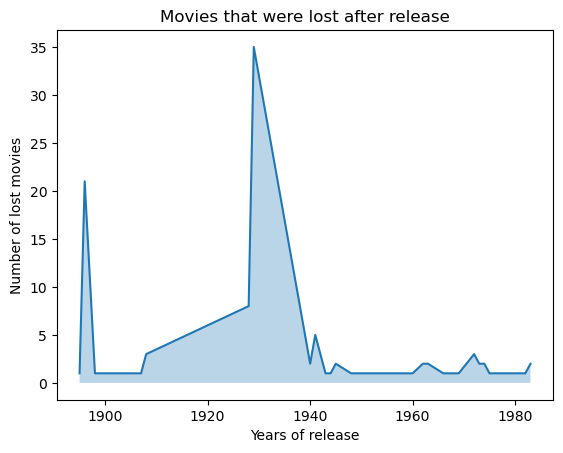

In [56]:
plt.plot(lost_stats_per_year.index.to_numpy(), lost_stats_per_year.values)
plt.fill_between(lost_stats_per_year.index.to_numpy(), lost_stats_per_year.values, alpha = 0.3)
plt.xlabel("Years of release")
plt.ylabel("Number of lost movies")
plt.title("Movies that were lost after release")
plt.show()

In [57]:
# Identify releasing years with more than five reported lossed movies
lost_stats_per_year.index[lost_stats_per_year.values >=5]

Index([1896, 1928, 1929, 1941], dtype='int64', name='Year')

In [58]:
print(lost_stats_per_year[lost_stats_per_year.index == 1896])
print(lost_stats_per_year[lost_stats_per_year.index == 1928])
print(lost_stats_per_year[lost_stats_per_year.index == 1929])
print(lost_stats_per_year[lost_stats_per_year.index == 1941])

Year
1896    21
Name: Year, dtype: int64
Year
1928    8
Name: Year, dtype: int64
Year
1929    35
Name: Year, dtype: int64
Year
1941    5
Name: Year, dtype: int64


Firstly, it is interesting to notice that there were two waves of loss, with respective peaks in 1896 and 1929. The second one could be explicated by the serie of vault fire in 1933, 1936 and 1937 that destroyed many movies. 
Secondly, it is also important to note that since 1983, no more lost movies were registered as lost, probably due to the apparition of new storage technology that are less vulnerable and from which copies are more easier made. 

### Silent & black and white films <a class="anchor" id="third_b"></a>

#### Data visualization: Silent films
Using the movies metadata, we should first need to make sure that the subset of silent films allows to perform an analysis of the transition from silent movies to synchronized score and sound films. For this purpose, we can plot the number of silent films released per year, and similarily the proportion of silent films per year, to observe a drastic decrease around 1930 correlating with the arrival of the technology.

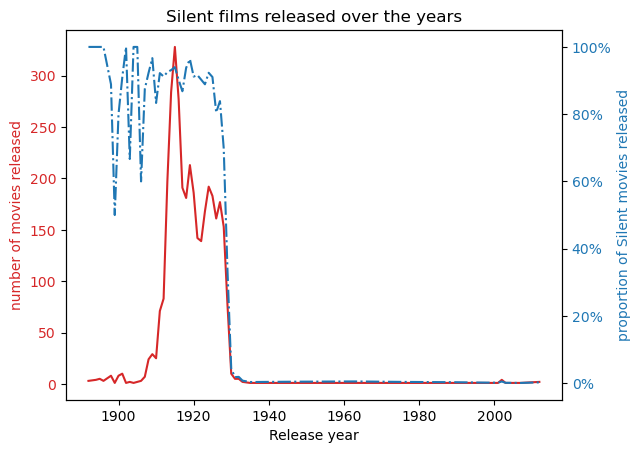

,frequency,total_nb_films
movie_release_date,,
1901,10,11
1904,1,1
1912,83,91
2001,1,713
1932,5,267


In [59]:
#Dataframe grouping Silent films by year and indicating the number of silent films relased, as well as the total number of films released in that year
mute_films, mute_films_by_year = release_by_genre(movies_df)
plot_release_by_genre(mute_films_by_year)

#Display resulting dataframe
display(mute_films_by_year.sample(5))

#### Using a subset of actors that have starred in at least one silent film

For the analysis of the impact of the arrival of synchronized sound and score in movies on the actor's career, we need to use a subset of actors that have starred in at least one silent movie. We observe here the distribution of number of movies (silent or not) for each actor in that subset.
Notice that the data is heavy-tailed (both axes are in logarithmic scale). A lot of actors in the subset have released only a small number of movies.

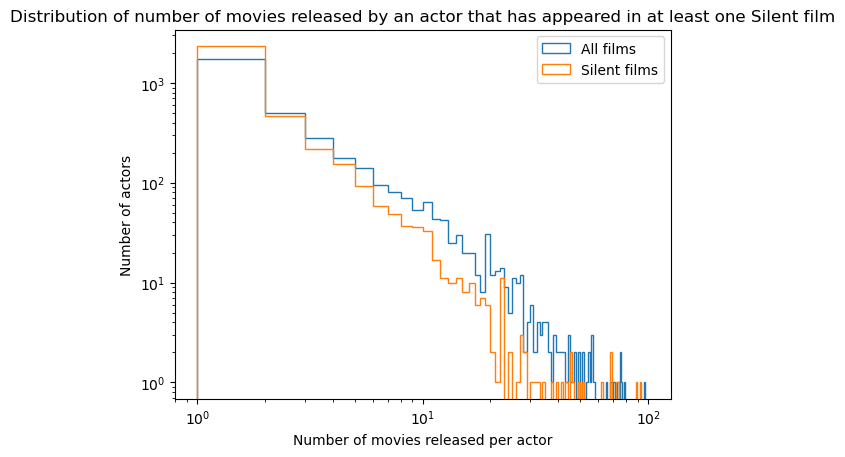

,birth_date,age_last_genre,Silent_appearances,non_Silent_appearances,total_appearances,nb_Silent_appearances,nb_non_Silent_appearances,nb_total_appearances,ratio
actor_name,,,,,,,,,
Cesarine Prinz\t,1883.0,39.0,[1922],[1926],"[1926, 1922]",1,1,2,1.0
'Big Bill' Giddinger,NaN,NaN,[1911],[],[1911],1,0,1,0.0
A. Edward Sutherland,1895.0,19.0,[1914],[],[1914],1,0,1,0.0
A. Longari,NaN,NaN,[1926],[],[1926],1,0,1,0.0
A. Risetto,NaN,NaN,[1930],[],[1930],1,0,1,0.0
...,...,...,...,...,...,...,...,...,...
Zoe Palmer,NaN,NaN,"[1921, 1921]",[1922],"[1922, 1921, 1921]",2,1,3,0.5
Zoe Rae,1910.0,5.0,[1915],[],[1915],1,0,1,0.0
Zoltán Szerémy,1861.0,57.0,[1918],[],[1918],1,0,1,0.0


In [60]:
#Character metadata grouped by acotrs, that have starred in at least one silent film 
#For each actor, we indicate the years the actor appears in a movie of the dataset
actors_silent = actors_by_genre(characters_df, mute_films)
plot_distrib_actors_by_genre(actors_silent)

#Display dataframe
display(actors_silent)

Similarly, we can visualize the distributions of the number of movies each of the silent film actors have appeared in. We can plot the distribution of number of silent films, non-silent films and all films per actor.
We can observe that the median of the middle distribution is at 0, meaning that at least half of the actors from the subset (ie. actors that have appeared in at least one silent film) have never acted in a non-silent film.

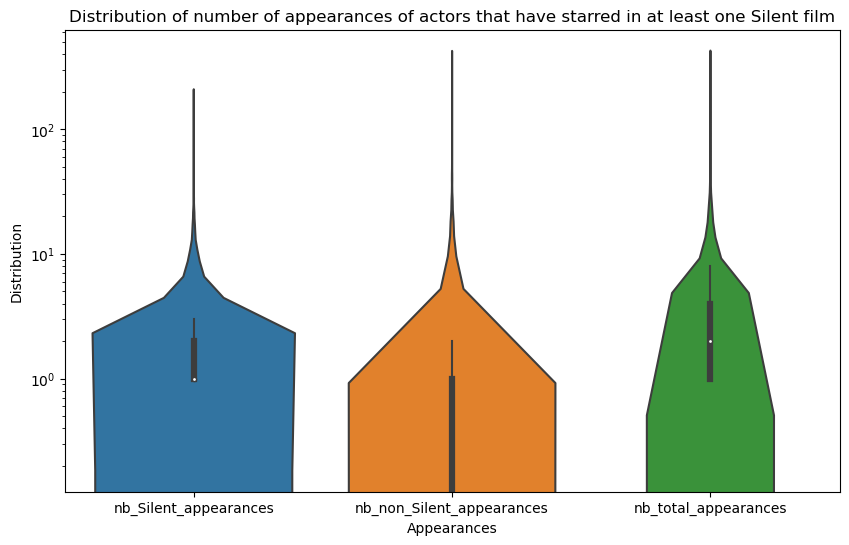

In [61]:
#Create dataframe suitable to plot violin plot for each column
genre = 'Silent'

df = pd.melt(actors_silent[['nb_{}_appearances'.format(genre), 'nb_non_{}_appearances'.format(genre), 'nb_total_appearances']].copy(), 
             var_name='Appearances', value_name='Distribution')

plt.figure(figsize=(10, 6))  # Adjust the figure size if needed
sns.violinplot(x='Appearances', y='Distribution', data=df)
plt.title('Distribution of number of appearances of actors that have starred in at least one Silent film')
plt.yscale('log')
plt.show()


#### Mean number of releases per actor

As a continuation, we can plot the mean number of movie releases across actors per year. This is done to see if there is a gradual decrease after the introduction of sound in the late 1920's. However there are a few things that are important to note:
- because our data is heavy-tailed, the use of the mean might not be the most appropriate choice, due to its sensitivity to extreme values. Using the median is not an alternative due to it being set to 0 all along. Similarly, the harmonic and geometric mean cannot deal with values set to 0.
- The death and retirement of these actors are a non-negligeable confounder of the decrease in activity after the introduction of sounds. For later analyses, we will in parallel observe the ages of each actor at the time of the transition to remove - to a certain degree- the confounder of death. Unfortunately we do not have the information relative to the actor's death in this dataset.

,count_silent,count_non_silent
actor_name,,
Cesarine Prinz\t,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
'Big Bill' Giddinger,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
A. Edward Sutherland,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
A. Longari,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
A. Risetto,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...
Zoe Palmer,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
Zoe Rae,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
Zoltán Szerémy,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


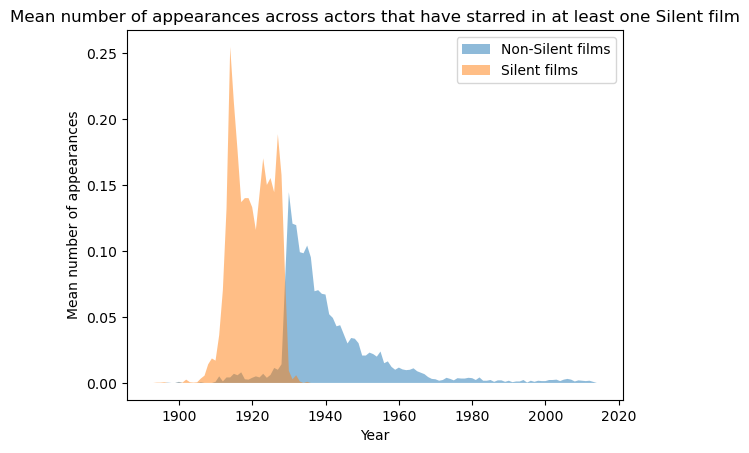

In [62]:
#Helper functions to create vector counting how many films the actor has appeared in for each year
def unique_years(x):
    years = []
    for year in x:
        if ~np.isin(year, years):
            years.append(year)
    return years
def count_per_year(x, range):
    years_appearance = unique_years(x)
    count = []
    for year in range:
        if np.isin(year, years_appearance):
            count.append(x.tolist().count(year))
        else:
            count.append(0)
    return np.asarray(count)

#range of years: 1888-2015
years = range(int(movies_df.movie_release_date.min()), int(movies_df.movie_release_date.max()))

# Create a new Dataframe containing the number of appearances of eah actor per year (1888-2015)
df_count_per_year = pd.DataFrame({'count_silent' : actors_silent['Silent_appearances'].copy().apply(lambda x : count_per_year(x, years)),
                       'count_non_silent' : actors_silent['non_Silent_appearances'].copy().apply(lambda x : count_per_year(x, years))})

#Display new dataframe
display(df_count_per_year)

#Plot the mean of appearances of actors per year
mean_silent_years = np.mean(np.stack(df_count_per_year.count_silent.values), axis = 0)
mean_non_silent_years = np.mean(np.stack(df_count_per_year.count_non_silent.values), axis = 0)

plt.fill_between(years, mean_non_silent_years, alpha = 0.5, label = 'Non-Silent films')
plt.fill_between(years, mean_silent_years, alpha = 0.5, label = 'Silent films')
plt.ylabel('Mean number of appearances')
plt.xlabel('Year')
plt.title('Mean number of appearances across actors that have starred in at least one Silent film')
plt.legend()
plt.show()


#### First Analysis : How many actors survived the "transition" from silent films to synchronized score and sound films?

We can now answer this question by using the ratio of non-Silent film releases over Silent film release for each actor. We have arbitrarily chosen that actors that have starred in as many non-silent films as silent films have  "survived" the transition. Any actor with a ratio below 1, we believe have not picked up their career after the transition in this first analysis. We have in parallel plotted the distributions of the age of the actor at their latest Silent film release.
- We can firstly see that majority of actors in the subset have not "survived that transition
- The average age of the actors at the time of their latest Silent film is around 40 years-old
- There is around 30% of missing data related to the age of the actors, which is non-negligeable and an obstacle to the analysis
- For further analyses, we could compute the same fractions but only for actors below 50 years old to limit the effect of the confounder of death and retirement.

Fraction of actors whose date of birth is missing: 31.55%
Fraction of actors whose age at latest Silent film is missing: 31.55% 

67.62% of actors that have starred in at least one silent film have not "survived" the arrival of synchrnized sound and scores in feature films.
The "survival" criterion is defined as such: if an actor has starred in at least as many non silent films as silent films, they have "survived" this transition. 



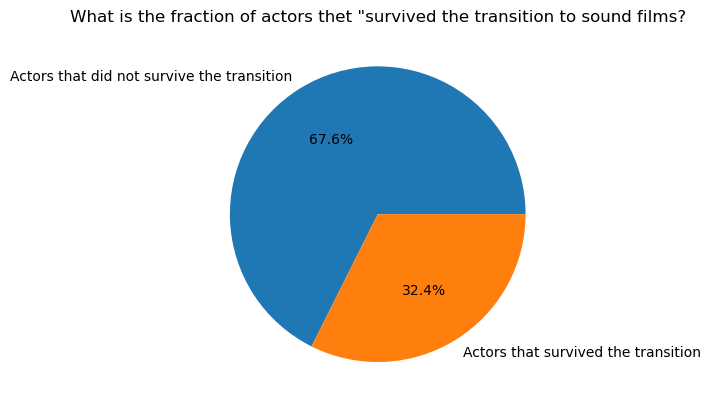

0.39% of actors are outliers: their age at latest silent film are below 0 or above 100 



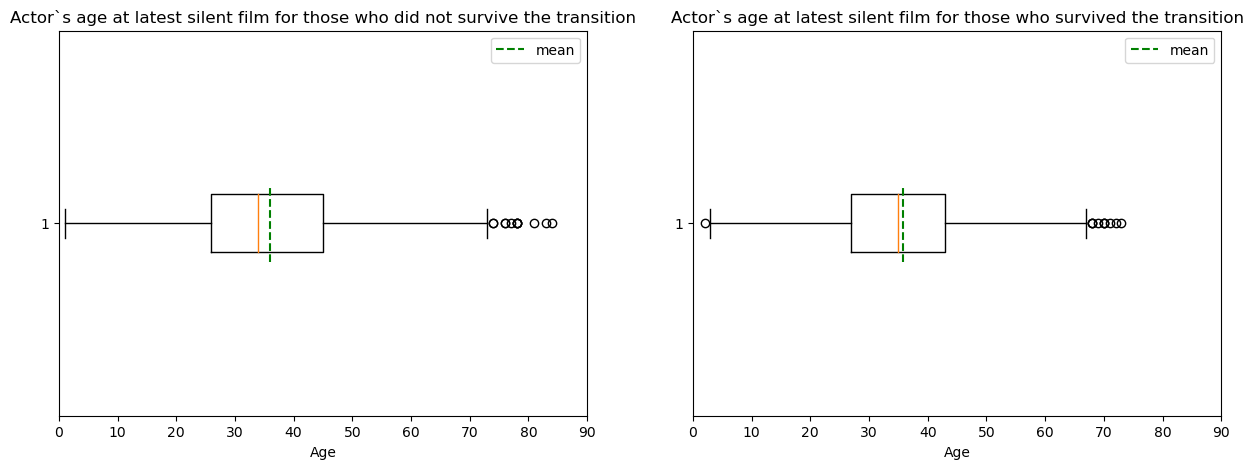

In [63]:
a = actors_silent['birth_date'].isna().sum()/actors_silent.shape[0]
b = actors_silent['age_last_genre'].isna().sum()/actors_silent.shape[0]

print('Fraction of actors whose date of birth is missing: {:.2%}'.format(a))
print('Fraction of actors whose age at latest Silent film is missing: {:.2%} \n'.format(b))

## Fraction of actors that "survived" transition
frac_min = 0.1
idx = actors_silent['ratio'].copy() <= frac_min
frac = idx.sum() / len(idx)

print('{:.2%} of actors that have starred in at least one silent film have not "survived" the arrival of synchrnized sound and scores in feature films.'.format(frac))
print('The "survival" criterion is defined as such: if an actor has starred in at least as many non silent films as silent films, they have "survived" this transition. \n')

#Pie chart
plt.pie([frac, 1-frac], labels = ['Actors that did not survive the transition', 'Actors that survived the transition'], autopct='%1.1f%%')
plt.title('What is the fraction of actors thet "survived the transition to sound films?')
plt.show()

## Average age of actors that "survived" transition
outliers = actors_silent[(actors_silent['age_last_genre'] <= 0) | (actors_silent['age_last_genre'] >= 100)].copy()
print('{:.2%} of actors are outliers: their age at latest silent film are below 0 or above 100 \n'.format(outliers.shape[0]/actors_silent.shape[0]))

actors_silent_filt = actors_silent[(actors_silent['age_last_genre'] > 0) & (actors_silent['age_last_genre'] < 100)].copy()

non_survivors = actors_silent_filt[actors_silent_filt['ratio'] <= frac_min].copy()
survivors = actors_silent_filt[actors_silent_filt['ratio'] >= frac_min].copy()

#Plot the age distributions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 5))
ax1.boxplot(data= non_survivors, x = 'age_last_genre', vert=False)
ax1.vlines(non_survivors.age_last_genre.mean(), ymin = 0.9, ymax = 1.1, color = 'green', ls= '--', label = 'mean')
ax1.set_xlim(0, 90)
ax1.set_xlabel('Age')
ax1.set_title('Actor`s age at latest silent film for those who did not survive the transition')
ax1.legend()

ax2.boxplot(data= survivors, x = 'age_last_genre', vert=False)
ax2.vlines(survivors.age_last_genre.mean(), ymin = 0.9, ymax = 1.1, ls= '--', color = 'green', label = 'mean')
ax2.set_xlim(0, 90)
ax2.set_xlabel('Age')
ax2.set_title('Actor`s age at latest silent film for those who survived the transition')
ax2.legend()
plt.show()


#### Data visualization: Black-and-White films and Animated films
Using the movies metadata, we chould perform the same analysis for black-and-white films and the transition to colored films, and the increase of animated films with better animation technologies. However, from the first plot we can observe the following: 
- The proportion of balck-and-white films released over the years, we can see that the transition is much more progressive than synchrnized score and sound films,
- Although the number of animated films have increased over the years, its proportion has remained stable.

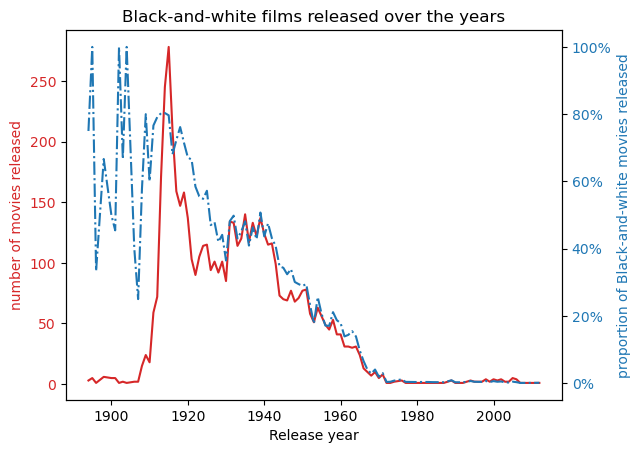

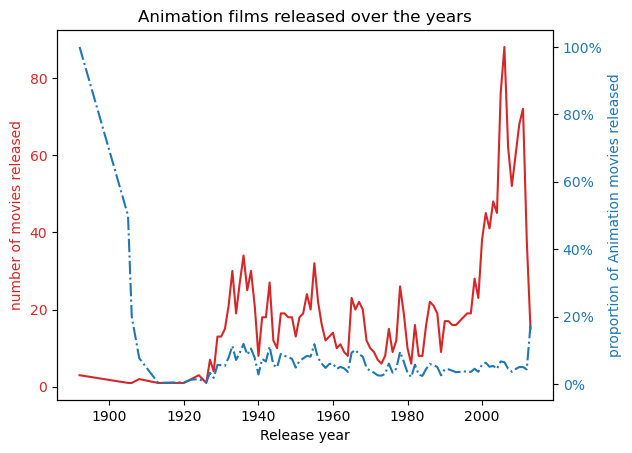

In [64]:
bw_films, bw_films_by_year = release_by_genre(movies_df, 'Black-and-white')
plot_release_by_genre(bw_films_by_year, 'Black-and-white')

anim_films, anim_films_by_year = release_by_genre(movies_df, 'Animation')
plot_release_by_genre(anim_films_by_year, 'Animation')

### Special effects <a class="anchor" id="third_c"></a>

## Focus: Technology in movies <a class="anchor" id="fourth"></a>

### Movies about technology <a class="anchor" id="fourth_a"></a>

#### Science fiction & fantasy <a class="anchor" id="fourth_a1"></a>

#### Keyphrase analysis <a class="anchor" id="fourth_a2"></a>

A big portion of the work needed to analyze technologies in films and in the movie industry lies in the analysis of the move plot summaries. 
Technically, this analysis is done by extracting the useful words in the plots. 
Hence, in this section we:
1) Seperate the movie IDs from the plots as dictionaries
2) Use the NTLK library to tokenize the movie plots
3) Define a list of words to use for the search
4) Count the number of movies that contain at least 1 word in the given list per year
5) Plot the result in a graph

In [65]:

# Read the plot summaries from the text file
with open(DATAFOLDER + 'plot_summaries.txt', 'r', encoding='utf-8') as file:
    lines = file.readlines()

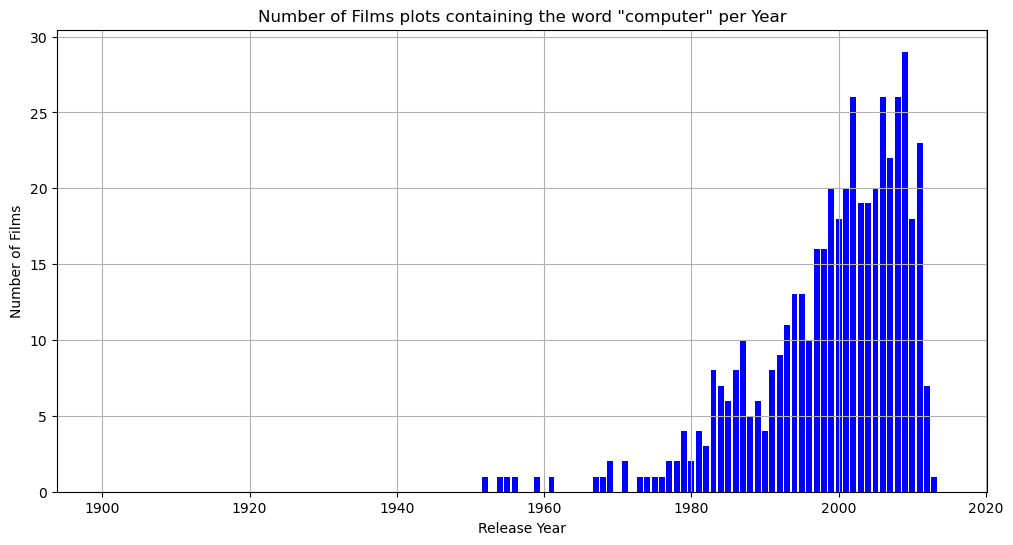

In [66]:
# Extract movie IDs and plot summaries and put them in separate lists.
movie_ids = []
plot_summaries = []

for line in lines:
    parts = line.split('\t')
    if len(parts) == 2:
        movie_id, summary = parts
        movie_ids.append(int(movie_id))
        plot_summaries.append(summary)

# Tokenize and preprocess the plot summaries
tokenized_summaries = []
for summary in plot_summaries:
    tokens = word_tokenize(summary)
    tokens = [word.lower() for word in tokens if word.isalpha()]
    tokens = [word for word in tokens if word not in stop_words]
    tokenized_summaries.extend(tokens)

# Define a list of technology-related keywords (to be modified at our convenience)
technology_keywords = ["computer", "computers","Computer", "Computers"]

# Create a dictionary to store film years based on movie IDs, with IDs as keys and movie plot summaries as values

film_years = {}
for index, row in movies_df.iterrows():
    film_years[row['movie_wikipedia_id']] = row['movie_release_date']
    
# Initialize a dictionary to store the film counts per year

film_counts_by_year = {year: 0 for year in range(1900, 2015)}

# Count the occurrence of technology-related keywords
technology_word_counts = Counter(word for word in tokenized_summaries if word in technology_keywords)

# Determine for which years films contain technology-related words and fill film_counts_by_year 
for movie_id in movie_ids:
    if movie_id in film_years:
        year = int(film_years[movie_id])
        if year in film_counts_by_year:
            summary = plot_summaries[movie_ids.index(movie_id)]
            if any(keyword in summary for keyword in technology_keywords):
                film_counts_by_year[year] += 1

# Create a list of years and corresponding film counts
years = list(film_counts_by_year.keys())
film_counts = list(film_counts_by_year.values())

# Plot the number of films containing technology-related words per year
plt.figure(figsize=(12, 6))
plt.bar(years, film_counts, color='b')
plt.title('Number of Films plots containing the word "computer" per Year')
plt.xlabel('Release Year')
plt.ylabel('Number of Films')
plt.grid(True)
plt.show()


#### Historical events <a class="anchor" id="fourth_a3"></a>

### Sentiment analysis <a class="anchor" id="fourth_b"></a>

## Next steps <a class="anchor" id="fifth"></a>

(Todo)